In [1]:
import numpy as np
import cvxpy as cp
import scipy
import mosek
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
n = 10  #number of stocks
T_train = 200 # training period
T_test = 100 #testing period
T_truetest = 100 # out of sample testing period

fulldata = np.load('fulldata_stocks.npy')

fulldata = 100*fulldata

#generating mask
def missing(miss_prob=0.4):
    #''True'' represents missing
    mask = np.random.choice([True, False], size = (T_train,n), p = [miss_prob, 1-miss_prob])
    mask = np.vstack((mask, np.full((T_test + T_truetest,n),False))) #no missing value for testing period
    return mask

In [3]:
#prior for the paramter \mu, use flat prior
mu_p = np.repeat(0.0,n)
covp_inv = np.diag(np.full(n,0.0))

def individualposterior(data, mask, mu0, cov0_inv,cov, num_points = 50):
    #compute mean and covariance of posterior of \mu given data up to time T in range(...)
    meanlist = []
    covariancelist = []
    num_posteriors = num_points + 1
    
    covariance_mu_inv = np.copy(cov0_inv)
    mean_mu = np.matmul(covariance_mu_inv,mu0)
    
    for t in range(T_train + T_test):
        
        if not np.all(mask[t,:] == np.full(n,True)):
            ind = (mask[t,:] == np.full(n,False))
            cov_t = cov[np.ix_(ind,ind)]
            cov_inv_expand = np.zeros((n,n))
            cov_inv_expand[np.ix_(ind,ind)] = scipy.linalg.pinv(cov_t)

            covariance_mu_inv += cov_inv_expand

            mean_t = np.zeros(n)
            mean_t[ind] = data[t,ind]
            mean_mu += np.matmul(cov_inv_expand,mean_t)
        
        if t >= (T_train - 1):
            if (t - T_train + 1) % (T_test/num_points) == 0:
                covariance_mu = scipy.linalg.pinv(covariance_mu_inv)
                covariancelist.append(covariance_mu)
                meanlist.append(np.matmul(covariance_mu, mean_mu))
    return meanlist,covariancelist  

In [4]:
def consensusforwardkl(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    gamma = cp.Variable(n)
    # v, s, vt = np.linalg.svd(covariancelist[0].values)
    
    s, v = np.linalg.eigh(covariancelist[0])
    
    s_list = []
    
    # s_list.append(s)
    
   
    
    # s, v = np.linalg.eigh(covariancelist[1].values)
    # s_list.append(s)
    
    # for i in np.arange(1,num_posteriors,1):
    for i in range(num_posteriors):
        s_temp = np.zeros(n)
        for j in range(n):
            s_temp[j] = np.inner(v[:,j],np.matmul(covariancelist[i],v[:,j]))
        s_list.append(s_temp)
        
    c = np.zeros((num_posteriors,n))
    
    for i in range(num_posteriors):
        for j in range(n):
            c[i, j] = np.inner(v[:,j],meanlist[i])/s_list[i][j]
            
        
    sv_matrix = np.array(s_list)        
    inverse_sv = 1.0 / sv_matrix
    
    #objective_fun = [cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights)),-1) for j in range(n)]
    
    obj = cp.sum([gamma[j] for j in range(n)])
    
    # Run optimization
    objective = cp.Minimize(obj)
    delta = delta_r * max([np.abs(c[-1,j]/inverse_sv[-1,j] - v[:,j].dot(prediction)) for j in range(n)])
    constraints = [weights >= 0,
                   cp.sum(weights) == 1]
    for j in range(n):
        constraints.append(cp.sum(cp.multiply(c[:,j],weights)) <= (delta + v[:,j].dot(prediction)) * cp.sum(cp.multiply(inverse_sv[:,j], weights)))
        constraints.append(cp.sum(cp.multiply(c[:,j],weights)) >= (-delta + v[:, j].dot(prediction)) * cp.sum(cp.multiply(inverse_sv[:,j], weights)))
        #constraints.append(4 +  cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights))-gamma[j],2)<= cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights))+gamma[j],2))   
        A = np.zeros((2,num_posteriors))
        B = np.zeros((2,n))
        B[1,j] = 1 
        for i in range(num_posteriors):
            A[1,i] = inverse_sv[i,j]
        C = np.zeros(2)
        C[0] = 2
        constraints.append(cp.SOC(A[1,:]@weights + B[1,:]@gamma, A @ weights - B @ gamma + C))
                           
                           
    prob = cp.Problem(objective, constraints)
   
    prob.solve()
    
    solution = weights.value
    #print(solution)
    #print(solution)
    
    final_sigma = scipy.linalg.inv(sum([solution[i] * scipy.linalg.inv(covariancelist[i]) for i in range(num_posteriors)]))
    final_mu = final_sigma.dot(sum([solution[i] * np.inner(scipy.linalg.inv(covariancelist[i]), meanlist[i]) for i in range(num_posteriors)]))
    
    return solution, final_mu, final_sigma

In [5]:
def consensuswasserstein(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    weights = cp.Variable(2)
        
    Sigma1 = covariancelist[0]
    Sigma2 = covariancelist[-1]
    temp = sqrtm(Sigma2) @ Sigma1 @ sqrtm(Sigma2)
    Psi = sqrtm(Sigma2) @ np.real(scipy.linalg.inv(sqrtm(temp))) @ sqrtm(Sigma2)
    
    P = np.zeros((2,2))
    P[0,0] = np.trace(Sigma1)
    P[1,1] = np.trace(Sigma2)
    P[0,1] = np.trace(Sigma1 @ Psi)
    P[1,0] = np.trace(Sigma1 @ Psi)
   
    obj = cp.quad_form(weights, P)
    
    constraints = [weights >= 0,
                   cp.sum(weights) == 1,
                   weights[1] <= delta_r]
    
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()
    
    solution = weights.value
   
    final_mu = meanlist[0] * solution[0] + meanlist[-1] * solution[1]
    final_sigma = (solution[0]*np.eye(n) + solution[1] * Psi) @ Sigma1 @ (solution[0]*np.eye(n) + solution[1] * Psi)
    
    return solution, final_mu, final_sigma

In [6]:
def consensuswasserstein_general(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    
    # v, s, vt = np.linalg.svd(covariancelist[0].values)
    
    s, v = np.linalg.eigh(covariancelist[0])
    
    s_list = []
    
    # for i in np.arange(1,num_posteriors,1):
    for i in range(num_posteriors):
        s_temp = np.zeros(n)
        for j in range(n):
            s_temp[j] = np.inner(v[:,j],np.matmul(covariancelist[i],v[:,j]))
        s_list.append(s_temp)
    
    sv_matrix = np.array(s_list)
    
    #P = np.zeros((num_posteriors,num_posteriors))
    #for i in range(num_posteriors): 
        #for j in range(num_posteriors):
            #P[i,j] = np.sum(np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:])))
            #np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:]))是(d_{i1}d_{j1})^{1/2}+...+(d_{in}d_{jn})^{1/2},其实可以换成np.inner的
            
    #obj = 0
    #for i in range(num_posteriors): 
    #    for j in range(num_posteriors):
    #        obj += weights[i] * weights[j] * np.sum(np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:])))
    
    
    #obj = cp.sum_squares(weights @ sv_matrix)
    obj = cp.sum_squares(sv_matrix.T @ weights.T)
    #obj = cp.quad_form(weights, P)
    delta = delta_r * np.linalg.norm(meanlist[-1] - prediction)
    constraints = [weights >= 0,
                   cp.sum(weights) == 1]
    temp = 0
    for i in range(num_posteriors):
        temp += weights[i]*meanlist[i]#\sum(\lambda_k\mu_k)
    constraints.append(cp.norm(temp-prediction)<=delta)
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    
    solution = weights.value
    
    
    final_mu = np.zeros(n)
    for i in range(num_posteriors):
        final_mu += solution[i]*meanlist[i]
    final_sigma = np.zeros((n,n))
    for i in range(num_posteriors):
        for j in range(n):
            final_sigma += solution[i] * np.sqrt(sv_matrix[i,j]) * np.outer(v[:,j],v[:,j])
    final_sigma = final_sigma @ final_sigma
    
    return solution, final_mu, final_sigma

In [7]:
def consensusbackwardkl(meanlist,covariancelist,delta_r,prediction,weight_init,epsilon,max_iter):#weight_init = np.full(num_posteriors,1/num_posteriors)
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    
    mu_list = []
    
    obj1 = 0
    for i in range(num_posteriors):
        mean_k = meanlist[i]
        mu_list.append(mean_k)
        obj1 += weights[i]*cp.trace(np.outer(mean_k,mean_k)+covariancelist[i])
        
    mu_matrix = np.array(mu_list)
    
    weight_t = weight_init
    weight_former = np.zeros(num_posteriors)
    iteration = 0
    
    while np.linalg.norm(weight_t-weight_former) > epsilon and iteration < max_iter:
        
        weight_former = weight_t
        
        #obj2 = 2*np.inner(np.matmul(mu_matrix,weight_t),np.matmul(mu_matrix,weights))
        obj2 = 2*(np.inner(weight_t,np.inner(mu_matrix,mu_matrix))@ weights)
        
        for i in range(num_posteriors):
            for j in range(num_posteriors):
                obj3 = -weight_t[i]*weight_t[j]*np.inner(meanlist[i],meanlist[j])
        
        obj = obj1+obj2+obj3
    
        delta = delta_r * np.linalg.norm(meanlist[-1] - prediction)
        constraints = [weights >= 0,
                   cp.sum(weights) == 1]
        temp = 0
        for i in range(num_posteriors):
            temp += weights[i]*meanlist[i]#\sum(\lambda_k\mu_k)
        constraints.append(cp.norm(temp-prediction,"inf")<=delta)
        #temp = 0
        #for j in range(n): #j:0,...n-1
        #    for i in range(num_posteriors):
        #        temp += weights[i]*meanlist[i][j]
        #    constraints.append(temp-prediction[j] <= delta)
        #    constraints.append(temp-prediction[j] >= -delta)
            
            
        prob = cp.Problem(cp.Minimize(obj), constraints)
        prob.solve(solver=cp.MOSEK)
    
        weight_t = weights.value
        iteration += 1
        print("weight diff:",np.linalg.norm(weight_t-weight_former))
        print("iteration:",iteration)
    
    final_mu = np.zeros(n)
    for i in range(num_posteriors):
        final_mu += weight_t[i]*meanlist[i]
        
    final_sigma = np.zeros((n,n))
    final_sigma_1 = np.zeros((n,n))
    for i in range(num_posteriors):
        final_sigma_1 += weight_t[i]*(np.outer(meanlist[i],meanlist[i])+covariancelist[i])
    final_sigma = final_sigma_1 - np.outer(final_mu,final_mu)
    
    return weight_t, final_mu, final_sigma

In [8]:
def imputation(data, mask, final_mu,final_sigma):    
    m = 100 #number of multiply-imputed dataset
    total_time,num_stocks = data.shape
    completed_data = np.zeros((m,total_time,num_stocks))
    for k in range(m):
        data_copy = np.copy(data)
        unconditionalmean = np.random.multivariate_normal(final_mu, final_sigma)
        for t in range(T_train):
            if np.all(mask[t,:] == np.full(n,True)):
                data_copy[t,:] = unconditionalmean
            elif np.all(mask[t,:] == np.full(n,False)):
                pass
            else:
                ind_miss = (mask[t,:] == np.full(n,True))
                ind_obs = (mask[t,:] == np.full(n,False))
                len_miss = len(data_copy[t,ind_miss])
                data_copy[t,ind_miss] = np.zeros(len_miss)
                cov11 = cov[np.ix_(ind_miss,ind_obs)]
                cov12_inv = np.linalg.inv(cov[np.ix_(ind_obs,ind_obs)])
                missing_condi_mean = unconditionalmean[ind_miss] + np.matmul(np.matmul(cov11,cov12_inv),data_copy[t,ind_obs] - unconditionalmean[ind_obs])
                missing_condi_cov = cov[np.ix_(ind_miss,ind_miss)] - np.matmul(cov11,np.matmul(cov12_inv,np.matrix.transpose(cov11)))
                data_copy[t,ind_miss] = missing_condi_mean
        completed_data[k,:,:] = data_copy
    return completed_data

In [9]:
def Greedy(data1):
    data = np.copy(data1)
    data = data/100
    mean = np.mean(np.exp(data[:T_train,:])-1.0,axis = 0)
    #if np.sum(mean) <= 0:
    #    print('whoops')
    weights = mean / np.linalg.norm(mean,2)
    #c_returns = 1.0
    returns = np.zeros(T_test)
    for t in np.arange(T_train,T_train+T_test,1):
        returns[t-T_train] = np.inner(np.exp(data[t,:])-1.0, weights)
        #c_returns *= 1.0 + returns[t-T_train]
    sharper = np.mean(returns)/np.std(returns)
    
    #o_returns = 1.0
    returns_o = np.zeros(T_truetest)
    for t in np.arange(T_train+T_test,T_train+T_test+T_truetest,1):
        returns_o[t-T_train - T_test] = np.inner(np.exp(data[t,:])-1.0, weights)
       # o_returns *= 1.0 + returns_o[t-T_train - T_test]
    o_sharper = np.mean(returns_o)/np.std(returns_o)
    
    return sharper, o_sharper,np.mean(returns),np.mean(returns_o)
    #return np.mean(returns),np.mean(returns_o)

In [25]:
n_experiment = 50
m = 100
 
num_delta = 10


mreturn_i_complex = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_wb = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_wb = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_wb_general = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_wb_general = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_kl_back = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_kl_back = np.zeros((n_experiment,m,num_delta))

cov = np.cov(np.matrix.transpose(fulldata))

In [26]:
for k in range(n_experiment):
    print(k)
    data = fulldata[:400,:]
    mask = missing()
    meanlist,covariancelist = individualposterior(data, mask, mu_p, covp_inv,cov)
    
    #get deltas
    deltalist_complex  = np.linspace(0.000, 1.0, num = num_delta)

    for i in range(num_delta):
        #print(i)
        _,final_mu,final_sigma = consensusforwardkl(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data = imputation(data,mask,final_mu,final_sigma)
        
        _,final_mu_wb,final_sigma_wb = consensuswasserstein(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data_wb = imputation(data,mask,final_mu_wb,final_sigma_wb)
        
        _,final_mu_wb_general,final_sigma_wb_general = consensuswasserstein_general(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data_wb_general = imputation(data,mask,final_mu_wb_general,final_sigma_wb_general)
        
        _,final_mu_kl_back,final_sigma_kl_back = consensusbackwardkl(meanlist,covariancelist,deltalist_complex[i],meanlist[0],np.full(len(meanlist),1/len(meanlist)),10**(-14),20)
        completed_data_kl_back = imputation(data,mask,final_mu_kl_back,final_sigma_kl_back)
        
        for j in range(m):
            _, _,mreturn_i_complex[k,j,i], mreturn_o_complex[k,j,i]  = Greedy(completed_data[j])
            _, _,mreturn_i_complex_wb[k,j,i], mreturn_o_complex_wb[k,j,i]  = Greedy(completed_data_wb[j])
            _, _,mreturn_i_complex_wb_general[k,j,i], mreturn_o_complex_wb_general[k,j,i]  = Greedy(completed_data_wb_general[j])
            _, _,mreturn_i_complex_kl_back[k,j,i], mreturn_o_complex_kl_back[k,j,i]  = Greedy(completed_data_kl_back[j])

0
weight diff: 0.9901475429687059
iteration: 1
weight diff: 3.4168529891193652e-12
iteration: 2
weight diff: 2.262507572219299e-16
iteration: 3
weight diff: 0.5569506127739142
iteration: 1
weight diff: 1.9704076415711577e-10
iteration: 2
weight diff: 2.232585852831311e-14
iteration: 3
weight diff: 2.1822537816114594e-14
iteration: 4
weight diff: 5.176266204770827e-15
iteration: 5
weight diff: 0.5866889683156004
iteration: 1
weight diff: 1.2612870860106149e-11
iteration: 2
weight diff: 2.1395196790803222e-10
iteration: 3
weight diff: 2.1396463358364213e-10
iteration: 4
weight diff: 1.3584069485544586e-10
iteration: 5
weight diff: 1.3579655868371286e-10
iteration: 6
weight diff: 7.696323619063285e-11
iteration: 7
weight diff: 4.1591377336337056e-10
iteration: 8
weight diff: 3.439074218617279e-10
iteration: 9
weight diff: 3.3310888269818504e-11
iteration: 10
weight diff: 3.331843701466778e-11
iteration: 11
weight diff: 4.393383699791772e-11
iteration: 12
weight diff: 4.3618542507325456e-1

weight diff: 1.4142135627390484
iteration: 7
weight diff: 1.4142135627390877
iteration: 8
weight diff: 1.4142135627393857
iteration: 9
weight diff: 1.4142135627393477
iteration: 10
weight diff: 1.4142135627392804
iteration: 11
weight diff: 1.414213562739282
iteration: 12
weight diff: 1.4142135624005827
iteration: 13
weight diff: 1.4142135624005823
iteration: 14
weight diff: 1.4142135623253504
iteration: 15
weight diff: 1.4142135623253513
iteration: 16
weight diff: 1.4142135627387702
iteration: 17
weight diff: 1.414213562738767
iteration: 18
weight diff: 1.4142135627391024
iteration: 19
weight diff: 1.4142135627391095
iteration: 20
weight diff: 0.9901475429800446
iteration: 1
weight diff: 1.414213562342512
iteration: 2
weight diff: 1.414213562339755
iteration: 3
weight diff: 1.414213562339805
iteration: 4
weight diff: 1.4142135623398058
iteration: 5
weight diff: 1.4142135623394592
iteration: 6
weight diff: 1.4142135623394585
iteration: 7
weight diff: 1.414213562339424
iteration: 8
weigh

weight diff: 1.414213562363171
iteration: 10
weight diff: 1.414213562363171
iteration: 11
weight diff: 1.4142135623637824
iteration: 12
weight diff: 1.4142135623637815
iteration: 13
weight diff: 1.4142135623637813
iteration: 14
weight diff: 1.4142135623637815
iteration: 15
weight diff: 1.4142135623632477
iteration: 16
weight diff: 1.4142135623632481
iteration: 17
weight diff: 1.414213562363171
iteration: 18
weight diff: 1.414213562363171
iteration: 19
weight diff: 1.4142135623637824
iteration: 20
3
weight diff: 0.9901475429237686
iteration: 1
weight diff: 5.2354476643507294e-11
iteration: 2
weight diff: 1.0653843204856494e-15
iteration: 3
weight diff: 0.6471031057774471
iteration: 1
weight diff: 0.12398741959316653
iteration: 2
weight diff: 0.12398741969028851
iteration: 3
weight diff: 0.12398743102576529
iteration: 4
weight diff: 0.12398743102520814
iteration: 5
weight diff: 0.12398743102493659
iteration: 6
weight diff: 0.12398743102563305
iteration: 7
weight diff: 0.12398743102587571

weight diff: 1.4142135619185923
iteration: 7
weight diff: 1.4142135619185905
iteration: 8
weight diff: 1.414213561918592
iteration: 9
weight diff: 1.4142135619185923
iteration: 10
weight diff: 1.414213561918593
iteration: 11
weight diff: 1.4142135619185918
iteration: 12
weight diff: 1.4142135619185874
iteration: 13
weight diff: 1.4142135619187777
iteration: 14
weight diff: 1.414213561918774
iteration: 15
weight diff: 1.4142135619185852
iteration: 16
weight diff: 1.414213561918571
iteration: 17
weight diff: 1.4142135619185716
iteration: 18
weight diff: 1.4142135619185752
iteration: 19
weight diff: 1.414213561918573
iteration: 20
4
weight diff: 0.9901475429898429
iteration: 1
weight diff: 5.739720159968644e-11
iteration: 2
weight diff: 4.2502779079247086e-11
iteration: 3
weight diff: 3.490230503397084e-11
iteration: 4
weight diff: 3.6394221839137466e-11
iteration: 5
weight diff: 1.0242300936914427e-09
iteration: 6
weight diff: 6.774244733947556e-15
iteration: 7
weight diff: 0.74558432694

weight diff: 1.4142135622034322
iteration: 12
weight diff: 1.4142135622034113
iteration: 13
weight diff: 1.4142135621918959
iteration: 14
weight diff: 1.4142135621918817
iteration: 15
weight diff: 1.4142135622178416
iteration: 16
weight diff: 1.4142135622178666
iteration: 17
weight diff: 1.4142135622184695
iteration: 18
weight diff: 1.4142135622184657
iteration: 19
weight diff: 1.414213562203418
iteration: 20
5
weight diff: 0.9901475429153108
iteration: 1
weight diff: 6.346985688104023e-11
iteration: 2
weight diff: 3.528676440312031e-15
iteration: 3
weight diff: 0.7230865439926978
iteration: 1
weight diff: 0.06923504897671254
iteration: 2
weight diff: 8.761809535238583e-10
iteration: 3
weight diff: 1.478608902922284e-11
iteration: 4
weight diff: 2.346528738020793e-14
iteration: 5
weight diff: 2.9375867785096e-14
iteration: 6
weight diff: 2.1359159802164038e-14
iteration: 7
weight diff: 1.7629634450912477e-10
iteration: 8
weight diff: 1.763611235810353e-10
iteration: 9
weight diff: 1.31

weight diff: 9.264481273178098e-12
iteration: 10
weight diff: 1.0407871621877859e-08
iteration: 11
weight diff: 1.0414354543473126e-08
iteration: 12
weight diff: 4.903096118590311e-12
iteration: 13
weight diff: 2.3920887100287524e-11
iteration: 14
weight diff: 2.9788944332677554e-10
iteration: 15
weight diff: 1.0127123597334717e-08
iteration: 16
weight diff: 1.0397223617676627e-08
iteration: 17
weight diff: 3.4639752526608813e-10
iteration: 18
weight diff: 1.0474164698219227e-08
iteration: 19
weight diff: 2.8529344441285332e-09
iteration: 20
weight diff: 0.6488345005761189
iteration: 1
weight diff: 2.053214268616999e-10
iteration: 2
weight diff: 1.8229476756987594e-14
iteration: 3
weight diff: 8.154334406300657e-15
iteration: 4
weight diff: 0.8025084119950943
iteration: 1
weight diff: 4.5942073032494465e-11
iteration: 2
weight diff: 2.9297216029071346e-12
iteration: 3
weight diff: 3.0035163385948333e-12
iteration: 4
weight diff: 2.8789487561793096e-13
iteration: 5
weight diff: 1.098018

weight diff: 7.762011014692255e-14
iteration: 7
weight diff: 1.389716875139041e-13
iteration: 8
weight diff: 4.324338274070674e-14
iteration: 9
weight diff: 4.761492231735914e-14
iteration: 10
weight diff: 1.0751677555826602e-13
iteration: 11
weight diff: 3.032875312550903e-13
iteration: 12
weight diff: 1.9218549125573893e-13
iteration: 13
weight diff: 2.8813603747928434e-13
iteration: 14
weight diff: 2.1437613356415293e-13
iteration: 15
weight diff: 2.443869210391603e-13
iteration: 16
weight diff: 2.687704724994607e-13
iteration: 17
weight diff: 1.0201406013200908e-13
iteration: 18
weight diff: 1.7833745224293367e-13
iteration: 19
weight diff: 1.913874611753156e-13
iteration: 20
weight diff: 0.5774968468728712
iteration: 1
weight diff: 0.6245199609324836
iteration: 2
weight diff: 0.5991889780897647
iteration: 3
weight diff: 0.599188977325577
iteration: 4
weight diff: 0.5991889773268273
iteration: 5
weight diff: 0.5991889773268299
iteration: 6
weight diff: 0.5991889773268337
iteration:

weight diff: 3.2855426169790506e-12
iteration: 7
weight diff: 2.6674145102758366e-12
iteration: 8
weight diff: 5.447753482567239e-12
iteration: 9
weight diff: 2.146708023587279e-11
iteration: 10
weight diff: 2.4543098365169846e-11
iteration: 11
weight diff: 2.748985567200214e-12
iteration: 12
weight diff: 3.3884155225345273e-12
iteration: 13
weight diff: 1.7567191567860132e-12
iteration: 14
weight diff: 5.951785503709445e-12
iteration: 15
weight diff: 5.809281971123597e-12
iteration: 16
weight diff: 1.5848302059278022e-12
iteration: 17
weight diff: 5.9080608811037285e-12
iteration: 18
weight diff: 4.0184603543811314e-12
iteration: 19
weight diff: 5.278476273298116e-12
iteration: 20
weight diff: 0.9901475429513413
iteration: 1
weight diff: 2.316872982335296e-11
iteration: 2
weight diff: 1.9211965351948462e-11
iteration: 3
weight diff: 2.0699997451517592e-11
iteration: 4
weight diff: 1.483371549027301e-12
iteration: 5
weight diff: 2.7923245244879846e-12
iteration: 6
weight diff: 2.796987

weight diff: 1.4142135623637242
iteration: 7
weight diff: 1.4142135623637229
iteration: 8
weight diff: 1.4142135623638086
iteration: 9
weight diff: 1.4142135623637813
iteration: 10
weight diff: 1.4142135623637822
iteration: 11
weight diff: 1.414213562363802
iteration: 12
weight diff: 1.414213562363812
iteration: 13
weight diff: 1.4142135623637944
iteration: 14
weight diff: 1.4142135623637895
iteration: 15
weight diff: 1.4142135623637813
iteration: 16
weight diff: 1.4142135623637848
iteration: 17
weight diff: 1.4142135623637773
iteration: 18
weight diff: 1.4142135623637688
iteration: 19
weight diff: 1.4142135623637744
iteration: 20
weight diff: 0.990147542688472
iteration: 1
weight diff: 1.4142135610351783
iteration: 2
weight diff: 1.4142135610811764
iteration: 3
weight diff: 1.4142135610811954
iteration: 4
weight diff: 1.4142135610812019
iteration: 5
weight diff: 1.4142135610812037
iteration: 6
weight diff: 1.4142135610812137
iteration: 7
weight diff: 1.4142135610811795
iteration: 8
we

weight diff: 1.4142135617599993
iteration: 11
weight diff: 1.4142135617599767
iteration: 12
weight diff: 1.4142135617599778
iteration: 13
weight diff: 1.4142135617599738
iteration: 14
weight diff: 1.414213561759969
iteration: 15
weight diff: 1.414213561759947
iteration: 16
weight diff: 1.41421356175996
iteration: 17
weight diff: 1.414213561759983
iteration: 18
weight diff: 1.414213561759973
iteration: 19
weight diff: 1.414213561759978
iteration: 20
weight diff: 0.9901475429766424
iteration: 1
weight diff: 1.4142135606722328
iteration: 2
weight diff: 1.4142135606702546
iteration: 3
weight diff: 1.4142135606702317
iteration: 4
weight diff: 1.4142135606702322
iteration: 5
weight diff: 1.4142135606702373
iteration: 6
weight diff: 1.4142135606702373
iteration: 7
weight diff: 1.4142135606702373
iteration: 8
weight diff: 1.4142135606702373
iteration: 9
weight diff: 1.4142135606702373
iteration: 10
weight diff: 1.4142135606702373
iteration: 11
weight diff: 1.4142135606702373
iteration: 12
weig

weight diff: 1.5716730546433804e-09
iteration: 11
weight diff: 1.7768780429252677e-09
iteration: 12
weight diff: 1.5433244125900268e-12
iteration: 13
weight diff: 1.7755418688888228e-09
iteration: 14
weight diff: 1.6228564803800003e-09
iteration: 15
weight diff: 1.7862280693119274e-10
iteration: 16
weight diff: 6.177281724093828e-13
iteration: 17
weight diff: 1.1664068492338858e-12
iteration: 18
weight diff: 3.381668768235841e-11
iteration: 19
weight diff: 3.2649854378619053e-11
iteration: 20
weight diff: 0.6784858289539188
iteration: 1
weight diff: 0.06905152904126322
iteration: 2
weight diff: 1.358714477654946e-09
iteration: 3
weight diff: 8.871554376155914e-11
iteration: 4
weight diff: 3.928257440758329e-09
iteration: 5
weight diff: 3.866902640307793e-09
iteration: 6
weight diff: 3.866671392357521e-09
iteration: 7
weight diff: 3.866805325221716e-09
iteration: 8
weight diff: 1.0866682374527865e-13
iteration: 9
weight diff: 3.867155175322284e-09
iteration: 10
weight diff: 9.9118924226

weight diff: 1.0309961868731607
iteration: 13
weight diff: 1.030996186873168
iteration: 14
weight diff: 1.0309961868731679
iteration: 15
weight diff: 1.0309961868731703
iteration: 16
weight diff: 1.0309961868731696
iteration: 17
weight diff: 1.0309961868731592
iteration: 18
weight diff: 1.0309961868731603
iteration: 19
weight diff: 1.0309961868731614
iteration: 20
weight diff: 0.7259938835393055
iteration: 1
weight diff: 0.6627829820461429
iteration: 2
weight diff: 0.6627829823051045
iteration: 3
weight diff: 0.6627829823050384
iteration: 4
weight diff: 0.6627829823050339
iteration: 5
weight diff: 0.6627829823050326
iteration: 6
weight diff: 0.6627829823050372
iteration: 7
weight diff: 0.6627829823050384
iteration: 8
weight diff: 0.6627829823050339
iteration: 9
weight diff: 0.6627829823050326
iteration: 10
weight diff: 0.6627829823050372
iteration: 11
weight diff: 0.6627829823050384
iteration: 12
weight diff: 0.6627829823050339
iteration: 13
weight diff: 0.6627829823050326
iteration: 1

weight diff: 1.3423035950610551
iteration: 18
weight diff: 1.3423035932548433
iteration: 19
weight diff: 1.3423035945643582
iteration: 20
weight diff: 0.990147541562055
iteration: 1
weight diff: 1.4142135612307285
iteration: 2
weight diff: 1.4142135622362624
iteration: 3
weight diff: 1.4142135622368643
iteration: 4
weight diff: 1.4142135622377319
iteration: 5
weight diff: 1.4142135622377114
iteration: 6
weight diff: 1.4142135622368242
iteration: 7
weight diff: 1.4142135622367893
iteration: 8
weight diff: 1.4142135622369902
iteration: 9
weight diff: 1.4142135622368355
iteration: 10
weight diff: 1.4142135622363177
iteration: 11
weight diff: 1.4142135622365113
iteration: 12
weight diff: 1.4142135622367977
iteration: 13
weight diff: 1.4142135622367595
iteration: 14
weight diff: 1.4142135622372642
iteration: 15
weight diff: 1.4142135622373102
iteration: 16
weight diff: 1.4142135622373335
iteration: 17
weight diff: 1.4142135622374046
iteration: 18
weight diff: 1.4142135622369403
iteration: 1

weight diff: 0.9901475428939899
iteration: 1
weight diff: 8.690309503680333e-11
iteration: 2
weight diff: 5.062624509053945e-14
iteration: 3
weight diff: 6.616934960747539e-14
iteration: 4
weight diff: 1.587619022336526e-14
iteration: 5
weight diff: 4.163346007777879e-14
iteration: 6
weight diff: 2.4980047376412247e-14
iteration: 7
weight diff: 5.551115124912642e-16
iteration: 8
weight diff: 0.9901475429744293
iteration: 1
weight diff: 4.014252748450492e-12
iteration: 2
weight diff: 1.1792122851189875e-11
iteration: 3
weight diff: 1.1774803372031985e-11
iteration: 4
weight diff: 2.9909408287234463e-12
iteration: 5
weight diff: 2.3725466040155403e-12
iteration: 6
weight diff: 1.669375748755155e-11
iteration: 7
weight diff: 2.656952436065945e-11
iteration: 8
weight diff: 9.27113942038907e-12
iteration: 9
weight diff: 1.2212453270923574e-14
iteration: 10
weight diff: 2.5204283157913034e-12
iteration: 11
weight diff: 2.8455016134624453e-12
iteration: 12
weight diff: 3.2789327014562692e-12


weight diff: 0.6951699144172847
iteration: 1
weight diff: 1.162404038798887
iteration: 2
weight diff: 1.1688361879468174
iteration: 3
weight diff: 1.1857102892939733
iteration: 4
weight diff: 1.1857102893117828
iteration: 5
weight diff: 1.185710289311681
iteration: 6
weight diff: 1.185710289311681
iteration: 7
weight diff: 1.1857102893118145
iteration: 8
weight diff: 1.1857102893118148
iteration: 9
weight diff: 1.1857102893118856
iteration: 10
weight diff: 1.1857102893118856
iteration: 11
weight diff: 1.1857102893115912
iteration: 12
weight diff: 1.1857102893115914
iteration: 13
weight diff: 1.1857102893118294
iteration: 14
weight diff: 1.1857102893118292
iteration: 15
weight diff: 1.1857102893117462
iteration: 16
weight diff: 1.1857102893117462
iteration: 17
weight diff: 1.1857102893117664
iteration: 18
weight diff: 1.1857102893117664
iteration: 19
weight diff: 1.1857102893117841
iteration: 20
weight diff: 0.7087543298435404
iteration: 1
weight diff: 0.9200884591230162
iteration: 2
we

weight diff: 1.6412633556071782e-11
iteration: 7
weight diff: 3.3899132329627297e-12
iteration: 8
weight diff: 3.390702192689767e-12
iteration: 9
weight diff: 4.012456985683002e-12
iteration: 10
weight diff: 2.9001165892487847e-11
iteration: 11
weight diff: 2.6643052940708275e-11
iteration: 12
weight diff: 1.3489041522859381e-11
iteration: 13
weight diff: 1.7960443307335682e-11
iteration: 14
weight diff: 1.9102716907929093e-12
iteration: 15
weight diff: 7.687766753246252e-12
iteration: 16
weight diff: 1.1269285319871468e-11
iteration: 17
weight diff: 2.9243516264633894e-12
iteration: 18
weight diff: 3.3306690754612447e-16
iteration: 19
weight diff: 0.7819275438708791
iteration: 1
weight diff: 1.3295980760996746e-09
iteration: 2
weight diff: 4.068347355619163e-14
iteration: 3
weight diff: 8.688869557449117e-16
iteration: 4
weight diff: 0.8945907328976492
iteration: 1
weight diff: 5.577010137657429e-10
iteration: 2
weight diff: 1.3863368958324318e-10
iteration: 3
weight diff: 1.386621760

weight diff: 1.4142135623336631
iteration: 6
weight diff: 1.4142135623331513
iteration: 7
weight diff: 1.4142135623331498
iteration: 8
weight diff: 1.414213562333132
iteration: 9
weight diff: 1.4142135623331322
iteration: 10
weight diff: 1.4142135623332683
iteration: 11
weight diff: 1.4142135623332681
iteration: 12
weight diff: 1.4142135623331293
iteration: 13
weight diff: 1.4142135623331296
iteration: 14
weight diff: 1.4142135623331347
iteration: 15
weight diff: 1.4142135623331331
iteration: 16
weight diff: 1.4142135623331449
iteration: 17
weight diff: 1.4142135623331469
iteration: 18
weight diff: 1.4142135623333592
iteration: 19
weight diff: 1.4142135623333592
iteration: 20
weight diff: 0.9901475429755343
iteration: 1
weight diff: 1.4142135623719132
iteration: 2
weight diff: 1.4142135623720908
iteration: 3
weight diff: 1.4142135623720975
iteration: 4
weight diff: 1.4142135623719816
iteration: 5
weight diff: 1.4142135623719818
iteration: 6
weight diff: 1.4142135623722347
iteration: 7


weight diff: 7.147257988892293e-13
iteration: 12
weight diff: 3.042688679553473e-13
iteration: 13
weight diff: 1.3209724612319765e-12
iteration: 14
weight diff: 6.368533198709397e-13
iteration: 15
weight diff: 3.1605002879854977e-14
iteration: 16
weight diff: 2.6755559795601813e-13
iteration: 17
weight diff: 7.494006309696062e-14
iteration: 18
weight diff: 7.994105479538805e-15
iteration: 19
weight diff: 0.9901475401884058
iteration: 1
weight diff: 2.7442972266095955e-09
iteration: 2
weight diff: 1.0536029852622909e-13
iteration: 3
weight diff: 1.0347279438152838e-13
iteration: 4
weight diff: 3.922575639883342e-15
iteration: 5
weight diff: 0.9901475430063643
iteration: 1
weight diff: 6.937765234383962e-11
iteration: 2
weight diff: 4.0414196965905206e-13
iteration: 3
weight diff: 3.671744571446699e-13
iteration: 4
weight diff: 1.4100942232909179e-14
iteration: 5
weight diff: 5.3068733536368626e-14
iteration: 6
weight diff: 3.9524839229506305e-14
iteration: 7
weight diff: 3.4952233347608

weight diff: 0.3841473305099892
iteration: 13
weight diff: 0.38414733050990657
iteration: 14
weight diff: 0.3841473305102164
iteration: 15
weight diff: 0.38414733051028044
iteration: 16
weight diff: 0.3841473305102862
iteration: 17
weight diff: 0.3841473305102912
iteration: 18
weight diff: 0.3841473305097048
iteration: 19
weight diff: 0.3841473305097556
iteration: 20
weight diff: 0.6539704691768843
iteration: 1
weight diff: 1.2246510267329813e-10
iteration: 2
weight diff: 1.5854876898926008e-12
iteration: 3
weight diff: 2.0505536641045063e-12
iteration: 4
weight diff: 2.7717867166976855e-12
iteration: 5
weight diff: 7.832630894541233e-15
iteration: 6
weight diff: 0.6210200267824513
iteration: 1
weight diff: 2.127766719922986e-10
iteration: 2
weight diff: 5.490468574575829e-14
iteration: 3
weight diff: 1.0481708918668983e-13
iteration: 4
weight diff: 4.8389713864066926e-14
iteration: 5
weight diff: 3.881012298816692e-14
iteration: 6
weight diff: 1.959293990406177e-14
iteration: 7
weight

weight diff: 4.175976074198566e-12
iteration: 11
weight diff: 1.16793496032579e-11
iteration: 12
weight diff: 1.1682792961905999e-11
iteration: 13
weight diff: 1.3426356273938036e-15
iteration: 14
weight diff: 0.9901475418089344
iteration: 1
weight diff: 1.5496825618145206e-09
iteration: 2
weight diff: 3.663736057673392e-15
iteration: 3
weight diff: 0.9901475421662143
iteration: 1
weight diff: 6.843372463377363e-10
iteration: 2
weight diff: 4.164531233092725e-15
iteration: 3
weight diff: 0.9901475418923962
iteration: 1
weight diff: 8.948678683476268e-10
iteration: 2
weight diff: 6.1595076102926534e-15
iteration: 3
25
weight diff: 0.9901475418069419
iteration: 1
weight diff: 4.972669453147037e-10
iteration: 2
weight diff: 3.155425335386573e-14
iteration: 3
weight diff: 2.021790862980146e-14
iteration: 4
weight diff: 2.9903953704132214e-15
iteration: 5
weight diff: 0.5965360729251766
iteration: 1
weight diff: 0.08377264930774835
iteration: 2
weight diff: 2.9628015501196487e-12
iteration:

weight diff: 0.619774381547831
iteration: 17
weight diff: 0.6197743815478323
iteration: 18
weight diff: 0.6197743815478235
iteration: 19
weight diff: 0.619774381547819
iteration: 20
weight diff: 0.6273843110584961
iteration: 1
weight diff: 0.9236519188167064
iteration: 2
weight diff: 0.9236519186850791
iteration: 3
weight diff: 0.9236519184409497
iteration: 4
weight diff: 0.9236519184409462
iteration: 5
weight diff: 0.9236519183113225
iteration: 6
weight diff: 0.9236519183111354
iteration: 7
weight diff: 0.9236519184407855
iteration: 8
weight diff: 0.9236519184412103
iteration: 9
weight diff: 0.9236519180395228
iteration: 10
weight diff: 0.9236519180394482
iteration: 11
weight diff: 0.9236519184410831
iteration: 12
weight diff: 0.9236519184408859
iteration: 13
weight diff: 0.9236519182100706
iteration: 14
weight diff: 0.923651918210206
iteration: 15
weight diff: 0.9236519184410525
iteration: 16
weight diff: 0.9236519184409576
iteration: 17
weight diff: 0.9236519195644387
iteration: 18


weight diff: 1.1549492419390193
iteration: 17
weight diff: 1.1549492534379115
iteration: 18
weight diff: 1.154949253437911
iteration: 19
weight diff: 1.1549492419390295
iteration: 20
weight diff: 0.8107255498489422
iteration: 1
weight diff: 1.1836001890916001
iteration: 2
weight diff: 1.1836001891013606
iteration: 3
weight diff: 1.1836001891013586
iteration: 4
weight diff: 1.183600189105768
iteration: 5
weight diff: 1.183600189105772
iteration: 6
weight diff: 1.183600189103991
iteration: 7
weight diff: 1.183600189103991
iteration: 8
weight diff: 1.1836001891016155
iteration: 9
weight diff: 1.1836001891016157
iteration: 10
weight diff: 1.1836001891030632
iteration: 11
weight diff: 1.1836001891030676
iteration: 12
weight diff: 1.1836001891051304
iteration: 13
weight diff: 1.183600189105125
iteration: 14
weight diff: 1.1836001891044468
iteration: 15
weight diff: 1.1836001891044485
iteration: 16
weight diff: 1.1836001891068046
iteration: 17
weight diff: 1.1836001891068033
iteration: 18
wei

29
weight diff: 0.9901475423947333
iteration: 1
weight diff: 6.227986575983027e-10
iteration: 2
weight diff: 4.002404646381101e-14
iteration: 3
weight diff: 2.917611165535376e-14
iteration: 4
weight diff: 1.1157983616264054e-14
iteration: 5
weight diff: 4.4330889478122426e-14
iteration: 6
weight diff: 2.373989058070515e-14
iteration: 7
weight diff: 1.1597597186464514e-14
iteration: 8
weight diff: 2.6876295733083103e-14
iteration: 9
weight diff: 1.2418334389954064e-14
iteration: 10
weight diff: 1.3275124953752373e-14
iteration: 11
weight diff: 7.776292966877419e-14
iteration: 12
weight diff: 3.5791650397775284e-14
iteration: 13
weight diff: 4.149073545679414e-14
iteration: 14
weight diff: 6.428362702266482e-14
iteration: 15
weight diff: 1.2724751018137903e-14
iteration: 16
weight diff: 1.5707704849051273e-14
iteration: 17
weight diff: 9.680090172234939e-14
iteration: 18
weight diff: 1.1438734739228537e-13
iteration: 19
weight diff: 9.5938380913014e-14
iteration: 20
weight diff: 0.556955

weight diff: 0.5006111183271715
iteration: 6
weight diff: 0.5006111183271723
iteration: 7
weight diff: 0.5006111183274417
iteration: 8
weight diff: 0.5006111183274438
iteration: 9
weight diff: 0.500611118327974
iteration: 10
weight diff: 0.5006111183280104
iteration: 11
weight diff: 0.5006111183274609
iteration: 12
weight diff: 0.50061111832742
iteration: 13
weight diff: 0.5006111183275537
iteration: 14
weight diff: 0.5006111183275576
iteration: 15
weight diff: 0.500611118327377
iteration: 16
weight diff: 0.5006111183273751
iteration: 17
weight diff: 0.5006111183279645
iteration: 18
weight diff: 0.5006111183279511
iteration: 19
weight diff: 0.5006111183273277
iteration: 20
weight diff: 0.8884937983381194
iteration: 1
weight diff: 0.16686383672577562
iteration: 2
weight diff: 0.16686383753371753
iteration: 3
weight diff: 0.16686383753368517
iteration: 4
weight diff: 0.16686383753368564
iteration: 5
weight diff: 0.16686383753371917
iteration: 6
weight diff: 0.1668638375338074
iteration: 

weight diff: 0.9901475425315786
iteration: 1
weight diff: 1.4142135620408811
iteration: 2
weight diff: 1.414213561991106
iteration: 3
weight diff: 1.4142135619911065
iteration: 4
weight diff: 1.4142135619919434
iteration: 5
weight diff: 1.4142135619919425
iteration: 6
weight diff: 1.4142135619911058
iteration: 7
weight diff: 1.4142135619911171
iteration: 8
weight diff: 1.4142135619901375
iteration: 9
weight diff: 1.4142135619900582
iteration: 10
weight diff: 1.4142135619910325
iteration: 11
weight diff: 1.4142135619911014
iteration: 12
weight diff: 1.414213561991106
iteration: 13
weight diff: 1.4142135619911065
iteration: 14
weight diff: 1.4142135619919434
iteration: 15
weight diff: 1.4142135619919425
iteration: 16
weight diff: 1.4142135619911058
iteration: 17
weight diff: 1.4142135619911171
iteration: 18
weight diff: 1.4142135619901375
iteration: 19
weight diff: 1.4142135619900582
iteration: 20
weight diff: 0.9901475429263665
iteration: 1
weight diff: 1.4142135622899077
iteration: 2
w

weight diff: 2.664608898227941e-08
iteration: 12
weight diff: 2.3926411282870495e-08
iteration: 13
weight diff: 2.3927791537250986e-08
iteration: 14
weight diff: 6.81511096907025e-08
iteration: 15
weight diff: 7.405071975861494e-08
iteration: 16
weight diff: 3.365600478724197e-08
iteration: 17
weight diff: 1.795464645013763e-08
iteration: 18
weight diff: 3.0221452597031055e-08
iteration: 19
weight diff: 2.387543486360218e-08
iteration: 20
weight diff: 0.6839639072370843
iteration: 1
weight diff: 4.8937717487884924e-11
iteration: 2
weight diff: 3.15786738705453e-14
iteration: 3
weight diff: 1.1501271244890642e-14
iteration: 4
weight diff: 1.267680792919649e-12
iteration: 5
weight diff: 1.2655990431390288e-12
iteration: 6
weight diff: 8.73802186359818e-15
iteration: 7
weight diff: 0.5744575819704612
iteration: 1
weight diff: 2.5457389589803294e-10
iteration: 2
weight diff: 3.446174259275879e-15
iteration: 3
weight diff: 0.6475348991532225
iteration: 1
weight diff: 0.6057837808434442
iter

weight diff: 1.4142135623669827
iteration: 17
weight diff: 1.4142135623669827
iteration: 18
weight diff: 1.4142135623669827
iteration: 19
weight diff: 1.4142135623669827
iteration: 20
weight diff: 0.9901475429460873
iteration: 1
weight diff: 1.414213562349799
iteration: 2
weight diff: 1.4142135623697014
iteration: 3
weight diff: 1.4142135623697012
iteration: 4
weight diff: 1.4142135623697019
iteration: 5
weight diff: 1.4142135623697016
iteration: 6
weight diff: 1.4142135623697012
iteration: 7
weight diff: 1.4142135623697016
iteration: 8
weight diff: 1.414213562369702
iteration: 9
weight diff: 1.4142135623697016
iteration: 10
weight diff: 1.4142135623697012
iteration: 11
weight diff: 1.4142135623697016
iteration: 12
weight diff: 1.414213562369702
iteration: 13
weight diff: 1.4142135623697016
iteration: 14
weight diff: 1.4142135623697012
iteration: 15
weight diff: 1.4142135623697016
iteration: 16
weight diff: 1.414213562369702
iteration: 17
weight diff: 1.4142135623697016
iteration: 18
w

weight diff: 7.859637126000958e-13
iteration: 5
weight diff: 7.346152387452592e-13
iteration: 6
weight diff: 2.8316994223288216e-13
iteration: 7
weight diff: 5.959505122539882e-13
iteration: 8
weight diff: 3.3377402799559945e-13
iteration: 9
weight diff: 1.4391572870326737e-13
iteration: 10
weight diff: 4.614741672851326e-13
iteration: 11
weight diff: 7.615651682284094e-13
iteration: 12
weight diff: 1.3990806550264263e-13
iteration: 13
weight diff: 8.202555580494686e-14
iteration: 14
weight diff: 5.045746911272539e-13
iteration: 15
weight diff: 1.589524905319331e-12
iteration: 16
weight diff: 5.747145206859113e-13
iteration: 17
weight diff: 4.922181053074351e-13
iteration: 18
weight diff: 9.451645092444214e-13
iteration: 19
weight diff: 1.1188905867948139e-13
iteration: 20
weight diff: 0.5331076257325223
iteration: 1
weight diff: 0.20954669486719307
iteration: 2
weight diff: 1.2488574758480744e-09
iteration: 3
weight diff: 5.561519977694284e-15
iteration: 4
weight diff: 0.7291357544050

weight diff: 2.7758446386029343e-13
iteration: 11
weight diff: 8.130137051018065e-13
iteration: 12
weight diff: 7.694078044674294e-13
iteration: 13
weight diff: 7.634190503513014e-13
iteration: 14
weight diff: 1.2453308392317742e-14
iteration: 15
weight diff: 2.5308300502096084e-14
iteration: 16
weight diff: 1.2363081428992829e-14
iteration: 17
weight diff: 6.009729772342029e-15
iteration: 18
weight diff: 0.515033572718411
iteration: 1
weight diff: 0.18368763458878648
iteration: 2
weight diff: 6.980929215478322e-10
iteration: 3
weight diff: 9.445614826877071e-16
iteration: 4
weight diff: 0.7013029898632748
iteration: 1
weight diff: 3.3381188421810445e-10
iteration: 2
weight diff: 2.4217545460604715e-11
iteration: 3
weight diff: 3.0050936896378335e-11
iteration: 4
weight diff: 5.391423762077637e-13
iteration: 5
weight diff: 5.983483848105707e-13
iteration: 6
weight diff: 1.1666539822818036e-13
iteration: 7
weight diff: 6.029939186255529e-14
iteration: 8
weight diff: 6.405470698843337e-1

weight diff: 0.5638418507982393
iteration: 1
weight diff: 0.6906714216197343
iteration: 2
weight diff: 0.6906714246856839
iteration: 3
weight diff: 0.690671424685673
iteration: 4
weight diff: 0.6906714246856726
iteration: 5
weight diff: 0.6906714246856736
iteration: 6
weight diff: 0.6906714246856741
iteration: 7
weight diff: 0.6906714246856808
iteration: 8
weight diff: 0.6906714246856772
iteration: 9
weight diff: 0.6906714246856749
iteration: 10
weight diff: 0.6906714246856784
iteration: 11
weight diff: 0.6906714246856779
iteration: 12
weight diff: 0.6906714246856774
iteration: 13
weight diff: 0.6906714246856747
iteration: 14
weight diff: 0.6906714246856757
iteration: 15
weight diff: 0.6906714246856747
iteration: 16
weight diff: 0.690671424685675
iteration: 17
weight diff: 0.6906714246856793
iteration: 18
weight diff: 0.6906714246856782
iteration: 19
weight diff: 0.690671424685677
iteration: 20
weight diff: 0.6450919170809958
iteration: 1
weight diff: 0.6830507599146021
iteration: 2
we

weight diff: 1.4142135622965426
iteration: 7
weight diff: 1.4142135622965455
iteration: 8
weight diff: 1.4142135623672007
iteration: 9
weight diff: 1.4142135623687093
iteration: 10
weight diff: 1.4142135623204382
iteration: 11
weight diff: 1.4142135623189953
iteration: 12
weight diff: 1.4142135622916183
iteration: 13
weight diff: 1.4142135622925593
iteration: 14
weight diff: 1.414213562346459
iteration: 15
weight diff: 1.414213562345452
iteration: 16
weight diff: 1.4142135621114362
iteration: 17
weight diff: 1.4142135621110772
iteration: 18
weight diff: 1.4142135622470189
iteration: 19
weight diff: 1.414213562245764
iteration: 20
weight diff: 0.9901475429762913
iteration: 1
weight diff: 1.4142135623473708
iteration: 2
weight diff: 1.4142135623485113
iteration: 3
weight diff: 1.414213562348513
iteration: 4
weight diff: 1.4142135623475989
iteration: 5
weight diff: 1.414213562347599
iteration: 6
weight diff: 1.4142135623490697
iteration: 7
weight diff: 1.4142135623490686
iteration: 8
weig

weight diff: 4.687805699177441e-12
iteration: 18
weight diff: 5.471845199174745e-12
iteration: 19
weight diff: 1.344058198072089e-11
iteration: 20
weight diff: 0.990147542976076
iteration: 1
weight diff: 6.446188285015927e-12
iteration: 2
weight diff: 3.1086267431851596e-15
iteration: 3
weight diff: 0.9901475429762057
iteration: 1
weight diff: 2.5791860996930314e-12
iteration: 2
weight diff: 6.287202674160572e-13
iteration: 3
weight diff: 6.258336755714256e-13
iteration: 4
weight diff: 2.3068219302024167e-12
iteration: 5
weight diff: 2.3108187385306736e-12
iteration: 6
weight diff: 6.550315845295467e-15
iteration: 7
41
weight diff: 0.9901475416617691
iteration: 1
weight diff: 1.4564974359135713e-09
iteration: 2
weight diff: 1.1151165845962144e-16
iteration: 3
weight diff: 0.5379388604911468
iteration: 1
weight diff: 1.29173067541797e-08
iteration: 2
weight diff: 2.7208369884662955e-08
iteration: 3
weight diff: 2.044762399419856e-08
iteration: 4
weight diff: 1.103385688380674e-08
iterat

weight diff: 0.3692649783793589
iteration: 15
weight diff: 0.369264978379342
iteration: 16
weight diff: 0.36926497810452663
iteration: 17
weight diff: 0.3692649781045079
iteration: 18
weight diff: 0.36926497826778837
iteration: 19
weight diff: 0.3692649782677927
iteration: 20
weight diff: 0.73496677147959
iteration: 1
weight diff: 0.5741947018502114
iteration: 2
weight diff: 0.033266316926251455
iteration: 3
weight diff: 9.099027155571567e-11
iteration: 4
weight diff: 2.667813315659801e-14
iteration: 5
weight diff: 2.2698240937581502e-14
iteration: 6
weight diff: 6.127279316409922e-11
iteration: 7
weight diff: 6.126995761576945e-11
iteration: 8
weight diff: 2.210412289968615e-14
iteration: 9
weight diff: 1.9716151212505615e-14
iteration: 10
weight diff: 6.475466729177446e-11
iteration: 11
weight diff: 6.475615265478866e-11
iteration: 12
weight diff: 1.1648483042661263e-14
iteration: 13
weight diff: 3.062790828093309e-10
iteration: 14
weight diff: 2.3075685956931307e-10
iteration: 15
we

weight diff: 0.10928509163752632
iteration: 7
weight diff: 0.10928509163752594
iteration: 8
weight diff: 0.10928509163752435
iteration: 9
weight diff: 0.1092850916379688
iteration: 10
weight diff: 0.10928509163796932
iteration: 11
weight diff: 0.1092850916375255
iteration: 12
weight diff: 0.10928509163752517
iteration: 13
weight diff: 0.10928509163752405
iteration: 14
weight diff: 0.10928509163752619
iteration: 15
weight diff: 0.10928509163752766
iteration: 16
weight diff: 0.10928509163752527
iteration: 17
weight diff: 0.10928509163752241
iteration: 18
weight diff: 0.10928509163752402
iteration: 19
weight diff: 0.10928509164314151
iteration: 20
weight diff: 0.9901475429709947
iteration: 1
weight diff: 3.449994722385752e-10
iteration: 2
weight diff: 7.333090849721126e-15
iteration: 3
weight diff: 0.9901475429443081
iteration: 1
weight diff: 7.433002487420724e-11
iteration: 2
weight diff: 5.884182030518928e-15
iteration: 3
weight diff: 0.9901475429762002
iteration: 1
weight diff: 7.56385

weight diff: 1.4142135623437482
iteration: 13
weight diff: 1.4142135623437453
iteration: 14
weight diff: 1.4142135623438732
iteration: 15
weight diff: 1.4142135623449654
iteration: 16
weight diff: 1.4142135623450223
iteration: 17
weight diff: 1.4142135623442538
iteration: 18
weight diff: 1.4142135623442191
iteration: 19
weight diff: 1.4142135623376684
iteration: 20
45
weight diff: 0.9901475429774227
iteration: 1
weight diff: 3.3748920840816365e-12
iteration: 2
weight diff: 5.551291292238712e-16
iteration: 3
weight diff: 0.6784369865857084
iteration: 1
weight diff: 0.6789765983141555
iteration: 2
weight diff: 0.6789765918130983
iteration: 3
weight diff: 0.6789765918130903
iteration: 4
weight diff: 0.6789765918133074
iteration: 5
weight diff: 0.6789765918133035
iteration: 6
weight diff: 0.6789765918135707
iteration: 7
weight diff: 0.678976591813619
iteration: 8
weight diff: 0.6789765918135972
iteration: 9
weight diff: 0.6789765918135066
iteration: 10
weight diff: 0.6789765918133046
itera

weight diff: 2.5615351218295694e-12
iteration: 6
weight diff: 4.0109736498047845e-12
iteration: 7
weight diff: 3.552591108255393e-12
iteration: 8
weight diff: 3.907290809007097e-12
iteration: 9
weight diff: 4.461570756576874e-12
iteration: 10
weight diff: 5.271894200391965e-13
iteration: 11
weight diff: 5.313031957674963e-13
iteration: 12
weight diff: 2.0155517483017925e-14
iteration: 13
weight diff: 8.479526035276046e-14
iteration: 14
weight diff: 2.927559140791279e-12
iteration: 15
weight diff: 2.8228343090958513e-12
iteration: 16
weight diff: 5.103848878943424e-14
iteration: 17
weight diff: 8.592651814965397e-13
iteration: 18
weight diff: 8.510109232818741e-13
iteration: 19
weight diff: 1.3686642244665551e-12
iteration: 20
weight diff: 0.7006897736065417
iteration: 1
weight diff: 0.939884137540211
iteration: 2
weight diff: 0.9398841375451837
iteration: 3
weight diff: 0.9398841375279825
iteration: 4
weight diff: 0.939884137524815
iteration: 5
weight diff: 0.9398841375420182
iteration

weight diff: 0.6817205208314651
iteration: 1
weight diff: 2.6869571285469572e-11
iteration: 2
weight diff: 7.862574822312766e-11
iteration: 3
weight diff: 7.859228547404802e-11
iteration: 4
weight diff: 4.704707207063208e-13
iteration: 5
weight diff: 3.004049980546021e-11
iteration: 6
weight diff: 2.2007474153075323e-11
iteration: 7
weight diff: 8.558821061535247e-12
iteration: 8
weight diff: 7.917821284952493e-14
iteration: 9
weight diff: 5.037662129940165e-11
iteration: 10
weight diff: 2.946791409857778e-11
iteration: 11
weight diff: 2.1221999804017587e-11
iteration: 12
weight diff: 1.1768938336979663e-13
iteration: 13
weight diff: 1.3997503754587699e-11
iteration: 14
weight diff: 3.7445524616676315e-11
iteration: 15
weight diff: 5.0997053506700906e-11
iteration: 16
weight diff: 1.7090627843374872e-13
iteration: 17
weight diff: 1.6495408341472432e-11
iteration: 18
weight diff: 3.114489113103639e-11
iteration: 19
weight diff: 4.733486912560305e-11
iteration: 20
weight diff: 0.86871424

weight diff: 1.7950713338678553e-14
iteration: 7
weight diff: 1.8401344833880522e-14
iteration: 8
weight diff: 1.535565277260129e-10
iteration: 9
weight diff: 3.808736843927506e-09
iteration: 10
weight diff: 4.075861055056378e-09
iteration: 11
weight diff: 4.075952317206009e-09
iteration: 12
weight diff: 3.6663152367282402e-09
iteration: 13
weight diff: 3.6662951470620494e-09
iteration: 14
weight diff: 4.1266297646385365e-09
iteration: 15
weight diff: 8.567712478418611e-10
iteration: 16
weight diff: 3.5565575842153965e-10
iteration: 17
weight diff: 3.66629698396553e-09
iteration: 18
weight diff: 5.399440559668791e-14
iteration: 19
weight diff: 3.66622597906425e-09
iteration: 20
weight diff: 0.9901475429782305
iteration: 1
weight diff: 1.224441154412562e-12
iteration: 2
weight diff: 9.836576063751693e-14
iteration: 3
weight diff: 4.218847507929545e-15
iteration: 4
weight diff: 0.9901475429785972
iteration: 1
weight diff: 2.512768765589376e-12
iteration: 2
weight diff: 4.864505479929155e

weight diff: 0.9901475425703455
iteration: 1
weight diff: 1.4142135468361752
iteration: 2
weight diff: 1.4142135472300494
iteration: 3
weight diff: 1.4142135472312651
iteration: 4
weight diff: 1.4142135472313242
iteration: 5
weight diff: 1.4142135472318622
iteration: 6
weight diff: 1.4142135472318966
iteration: 7
weight diff: 1.4142135472303647
iteration: 8
weight diff: 1.4142135472303414
iteration: 9
weight diff: 1.4142135472318698
iteration: 10
weight diff: 1.4142135472318433
iteration: 11
weight diff: 1.414213547230131
iteration: 12
weight diff: 1.4142135472301436
iteration: 13
weight diff: 1.4142135472316057
iteration: 14
weight diff: 1.4142135472315933
iteration: 15
weight diff: 1.414213547231842
iteration: 16
weight diff: 1.4142135472319424
iteration: 17
weight diff: 1.4142135472304256
iteration: 18
weight diff: 1.4142135472301962
iteration: 19
weight diff: 1.4142135472317157
iteration: 20


In [27]:
sds_r = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r[:,i] = mreturn_i_complex[:,:,i].flatten()
    
sds_o_r = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r[:,i] = mreturn_o_complex[:,:,i].flatten()

sds_r_wb = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_wb[:,i] = mreturn_i_complex_wb[:,:,i].flatten()

sds_o_r_wb = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_wb[:,i] = mreturn_o_complex_wb[:,:,i].flatten()

sds_r_wb_general = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_wb_general[:,i] = mreturn_i_complex_wb_general[:,:,i].flatten()

sds_o_r_wb_general = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_wb_general[:,i] = mreturn_o_complex_wb_general[:,:,i].flatten()
    
sds_r_kl_back = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_kl_back[:,i] = mreturn_i_complex_kl_back[:,:,i].flatten()

sds_o_r_kl_back = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_kl_back[:,i] = mreturn_o_complex_kl_back[:,:,i].flatten()

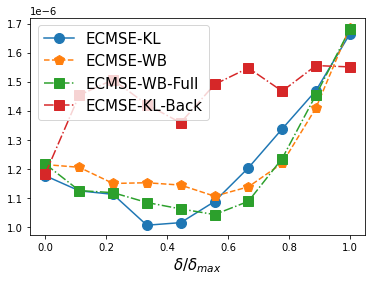

In [28]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r - sds_o_r,axis=0),0),2)),marker="o",markersize=10,label = "ECMSE-KL")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2)),marker="p",markersize=10,linestyle='dashed', label = "ECMSE-WB")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2)),marker="s",markersize=10,linestyle='-.', label = "ECMSE-WB-Full")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2)),marker="s",markersize=10,linestyle='-.', label = "ECMSE-KL-Back")


plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

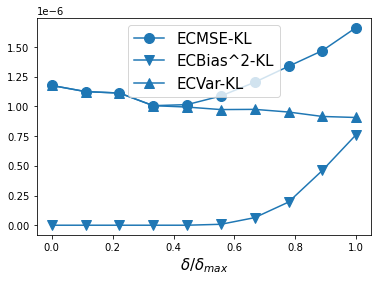

In [29]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r - sds_o_r,axis=0),0),2)),marker="o",markersize=10,label = "ECMSE-KL")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2),marker="v",markersize=10,color = '#1f77b4', label = "ECBias^2-KL")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0),marker="^",markersize=10,color='#1f77b4',label = "ECVar-KL")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

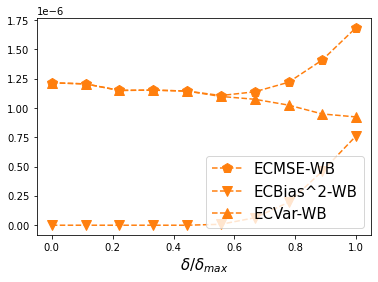

In [30]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2)),marker="p",markersize=10,linestyle='dashed',color='#ff7f0e',label = "ECMSE-WB")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2),marker="v",markersize=10,color='#ff7f0e',linestyle='dashed',label = "ECBias^2-WB")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0),marker="^",markersize=10,color='#ff7f0e',linestyle='dashed',label = "ECVar-WB")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

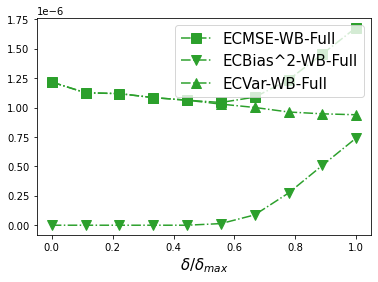

In [31]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2)),marker="s",markersize=10,linestyle='-.',color='#2ca02c',label = "ECMSE-WB-Full")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2),marker="v",markersize=10,color='#2ca02c',linestyle='-.',label = "ECBias^2-WB-Full")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0),marker="^",markersize=10,color='#2ca02c',linestyle='-.',label = "ECVar-WB-Full")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

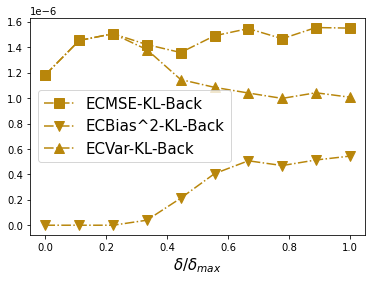

In [32]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2)),marker="s",markersize=10,linestyle='-.',color='#B8860B',label = "ECMSE-KL-Back")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2),marker="v",markersize=10,color='#B8860B',linestyle='-.',label = "ECBias^2-KL-Back")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0),marker="^",markersize=10,color='#B8860B',linestyle='-.',label = "ECVar-KL-Back")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()